In [4]:
LOCAL_JUPYTER = True

# Understanding Wine Trends across different attributes

Authors - Eliezer Pekar 212029052 | Sapir Caduri 303083653


The goal of this research is to develop a predictive model to identify the quality of wine based on various attributes such as location, price, and others. The research is using a Wine Review dataset from Kaggle, that is motivated by the documentary "Somm" which explores the world of master sommeliers and their ability to identify wines through blind tasting.

The work is based on this dataset from Kaggle:
https://www.kaggle.com/datasets/zynicide/wine-reviews

In this paper we explore the relationship between wine attributes (e.g., price, rating, regions) and their quality - we assume that the higher the pricer the higher the rating, we can try to predict the rating of the winer based on the price.


# 1. The Dataset

The Wine Reviews dataset contains information about various wines, including details such as country of origin, designation, points, price, province, region, variety, and winery. Number of rows: 119,955 (~25k unique reviews), 14  attributes


### Challenges with the data


The Wine Reviews dataset presents several challenges and difficulties that may arise during data analysis and modeling:
1. Missing Data/Empty rows: Designation 29% null, Null cells: Region 16% null, region2 61% null, taster_name 20% null, taster_twitter_handle 24% empty
2. Free text: The Description column contains textual descriptions of the wines
3. Biasing: Tiger Voss 20% of the reviews (@vossroger)
4. Outlier:
5. Imbalance: wine variety or quality = Some wine varieties or regions are heavily represented in the dataset = Pinot Noir 10%, Chardonnay 9%, other 81%, Region 2 9% Central coast
6. Categorical Variables: The dataset contains categorical variables such as "Winery" with 16K unique wineries (of 199K rows)
7. High Dimensionality: The dataset have a large number of attributes - can pose challenges for modeling and visualization

## Imports

In [89]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import contextlib
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline   # Import the Pipeline class
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from io import StringIO
import shap
from textblob import TextBlob
import joblib
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor


ModuleNotFoundError: No module named 'catboost'

In [6]:
# @title Kaggle API
if not LOCAL_JUPYTER:
    from google.colab import files

    with StringIO() as temp_output, contextlib.redirect_stdout(temp_output):
        files.upload() # This won't print to the screen the Kaggle API key

    # Move the API key into the required directory
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    !kaggle datasets download -d zynicide/wine-reviews

# 2. Analyzing the dataset

The dataset source: https://www.kaggle.com/datasets/zynicide/wine-reviews


The dataset initially appears to contain three files; however, analysis shows they are actually different versions of the same dataset.

In [7]:
wine_data_1 = pd.read_csv("./wine-reviews/winemag-data_first150k.csv")
# wine_data_2 = pd.read_json("./wine-reviews/winemag-data-130k-v2.json") # Same data, different format (json vs csv)
wine_data_3 = pd.read_csv("./wine-reviews/winemag-data-130k-v2.csv")

This is the first dataset:

In [8]:
wine_data_1.head(1)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz


In [9]:
wine_data_3.head(1)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia


In [10]:
def print_wine_attributes(wine_data):
  print("Wine attributes: ")
  for idx, column_name in enumerate(wine_data.columns):
      if pd.api.types.is_numeric_dtype(wine_data[column_name]):
          value_min = wine_data[column_name].min()
          value_max = wine_data[column_name].max()
          print(f"{idx}. {column_name} (Range: {value_min} - {value_max})")
      else:
          print(f"{idx}. {column_name}") # Range: Not applicable (non-numeric data)
          pass

## Attributes

In [11]:
print(fr"The shape of the dataset: {wine_data_1.shape}")
print_wine_attributes(wine_data_1)

The shape of the dataset: (150930, 11)
Wine attributes: 
0. Unnamed: 0 (Range: 0 - 150929)
1. country
2. description
3. designation
4. points (Range: 80 - 100)
5. price (Range: 4.0 - 2300.0)
6. province
7. region_1
8. region_2
9. variety
10. winery


In [12]:
print(fr"The shape of the dataset: {wine_data_3.shape}")
print_wine_attributes(wine_data_3)

The shape of the dataset: (129971, 14)
Wine attributes: 
0. Unnamed: 0 (Range: 0 - 129970)
1. country
2. description
3. designation
4. points (Range: 80 - 100)
5. price (Range: 4.0 - 3300.0)
6. province
7. region_1
8. region_2
9. taster_name
10. taster_twitter_handle
11. title
12. variety
13. winery


> We see that the file "winemag-data-130k-v2.csv" represents the most updated version of the wine review dataset. This version includes three new fields (Title, Taster Name, and Taster Twitter Handle), fixes duplicate entries found in earlier releases, and adds approximately 25,000 unique wine reviews.
This is why we will work in this project with the second one. 

In [13]:
wine_data = wine_data_3.copy()

The problem that we stated that we want to inquire is if the price can be predicted by other elements of the data.

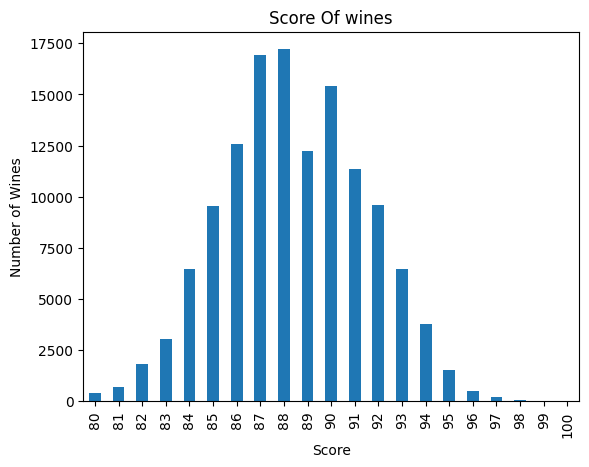

In [14]:
wine_data['points'].value_counts().sort_index().plot.bar(title = 'Score Of wines')
plt.xlabel('Score')  # Adding x-axis label
plt.ylabel('Number of Wines')  # Adding y-axis label
plt.show()

As we can see the scores are almost gaussian distributed. The minimum value is 80.

In [15]:
def print_skewness_and_kurtosis(data, feature, bins):
    print('Skewness=%.3f' % data[feature].skew())
    print('Kurtosis=%.3f' % data[feature].kurtosis())
    sns.histplot(data[feature], bins=bins, kde=True)
    plt.show()

Skewness=0.046
Kurtosis=-0.296


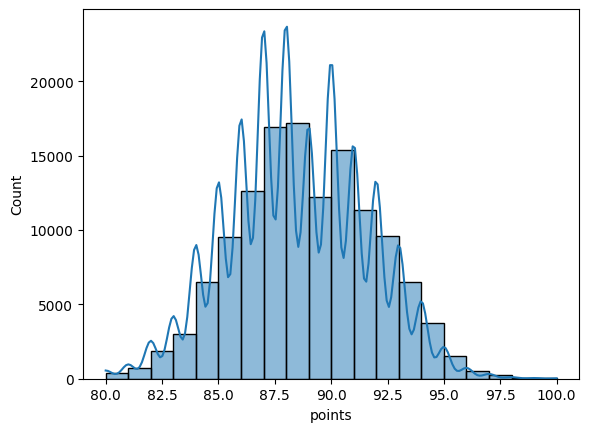

In [16]:
print_skewness_and_kurtosis(wine_data, 'points', 20)

Skewness=18.001
Kurtosis=829.520


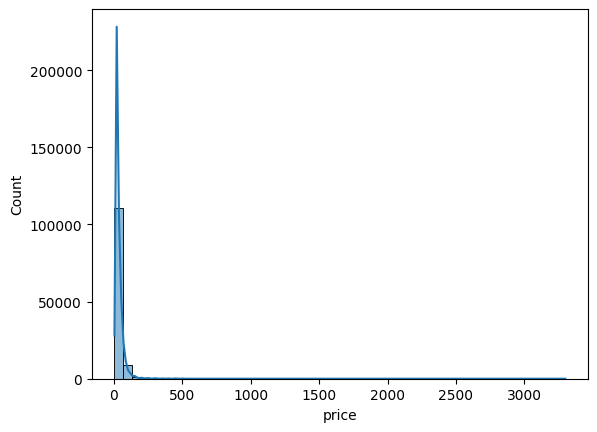

In [17]:
print_skewness_and_kurtosis(wine_data, 'price', 50)

Kurtosis indicates how much data resides in the tails. Distributions with a large kurtosis have more tail data than normally distributed data, which appears to bring the tails in toward the mean.

# 3. The prediction problem

In this notebook we explore the relationship between wine attributes (e.g., price, rating, regions) and their quality - we assume that the higher the pricer the higher the rating, we can try to predict the rating of the winer based on the price.

The task is: to predict wine quality (also referrred as points / wine review's score) based on the wine attributes.

# 4. Organization of the dataset

Let's see What are the missing values in the dataset:

In [76]:
print(wine_data.isnull().sum())

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64


Cells without price should be removed from the data as we understand that this is the most important property for review score prediction.

In [77]:
wine_data=wine_data.dropna(subset=['price'])
print(fr"Number of rows after the filtering: {wine_data.shape[0]}")
# training2_filtered=training2_without_null_price.dropna(subset=['country'])
# print(fr"Number of rows after the filtering: {training2_filtered.isnull().sum()}")

Number of rows after the filtering: 120975


# 5. meaningful data visualizations

Text(0, 0.5, 'Number of Wines')

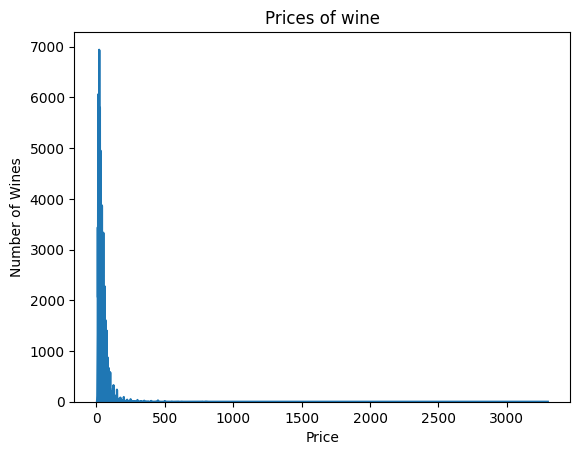

In [78]:
wine_data['price'].value_counts().sort_index().plot.area(title = 'Prices of wine')
plt.xlabel('Price')
plt.ylabel('Number of Wines')

We see a lot of outliers, let's trim all the expensive but rare wines

Text(0, 0.5, 'Number of Wines')

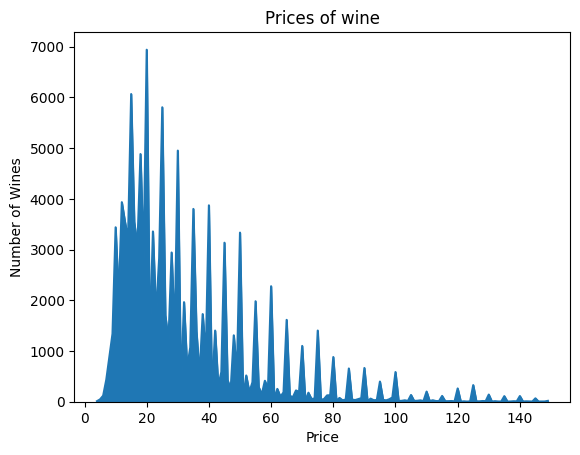

In [79]:
wine_data['price'][wine_data['price'] < 150].value_counts().sort_index().plot.area(title = 'Prices of wine')
plt.xlabel('Price')
plt.ylabel('Number of Wines')

The displayed area plot illustrates the distribution of wine prices under $150. Notably, the distribution exhibits a pronounced right skew, indicating a higher frequency of lower-priced wines within the dataset. This skewness suggests that more affordable wine options overwhelmingly outnumber their higher-priced counterparts. This will make it harder to predict higher-priced wines.

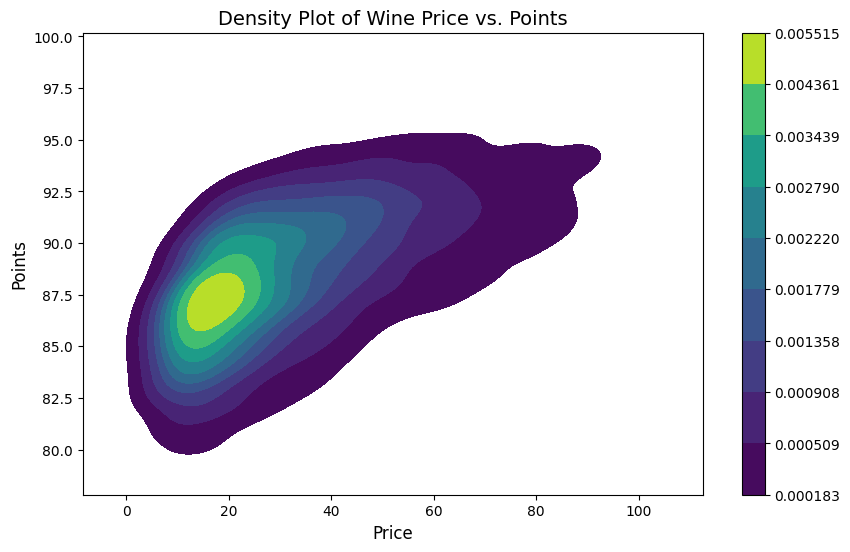

In [80]:
data_sample = wine_data.copy()
data_sample = data_sample[data_sample['price'] < 100].loc[:, ['price', 'points']].dropna().sample(5000)

plt.figure(figsize=(10, 6))
sns.kdeplot(
    x=data_sample['price'],
    y=data_sample['points'],
    cmap="viridis",
    fill=True,
    cbar=True,
    thresh=0.05,
)

plt.xlabel('Price', fontsize=12)
plt.ylabel('Points', fontsize=12)
plt.title('Density Plot of Wine Price vs. Points', fontsize=14)

plt.show()

The graph is a two-dimensional Kernel Density Estimate (KDE) plot that visualizes the joint distribution of wine prices and quality points. The color gradients represent the density of observations, with warmer colors indicating higher concentrations of wines within specific price and point ranges.

### Is there correlation of the price and points?

In [81]:
correlation = wine_data[['price', 'points']].corr().iloc[0, 1]
print(f"The Pearson correlation coefficient between price and points is: {correlation:.2f}")

The Pearson correlation coefficient between price and points is: 0.42


A correlation coefficient of 0.42 suggests a moderate positive relationship between the price and points of the wines in the dataset. However this relationship is not particularly strong.

### Examine variety - The type of grapes used to make the wine (ie Pinot Noir)

<Axes: xlabel='variety', ylabel='points'>

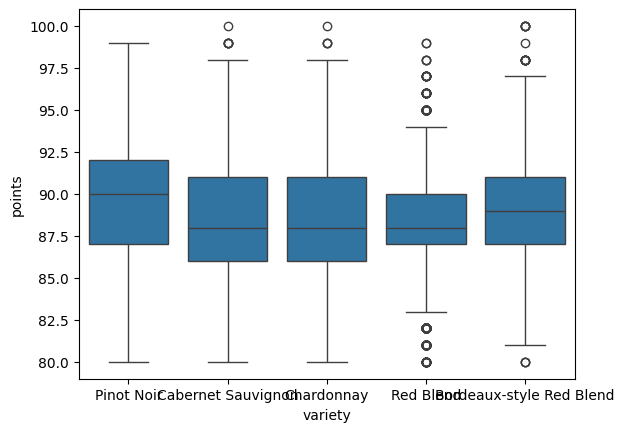

In [82]:
sns.boxplot(
    x = 'variety',
    y = 'points',
    data = wine_data[wine_data.variety.isin(wine_data.variety.value_counts().head(5).index)]
)

In the above we can see that different varieties of wine have different distribution of quality, meaning the the variety of the wine has effect on the user's final review. So we want to use this feature.

# The tasters reviews

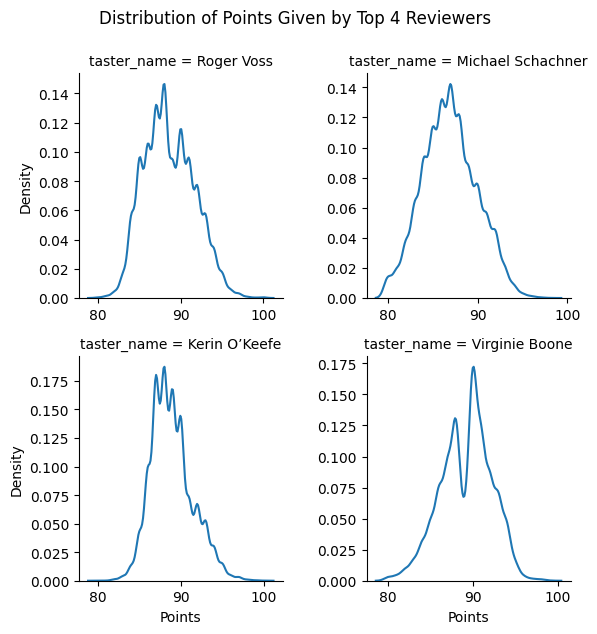

In [83]:
top_reviewers = wine_data['taster_name'].value_counts().nlargest(4).index

# Filter the data to include only the top reviewers
top_reviewers_data = wine_data[wine_data['taster_name'].isin(top_reviewers)]

# A FacetGrid KDE plot for the point distributions of the top 4 reviewers
g = sns.FacetGrid(top_reviewers_data, col='taster_name', col_wrap=2, sharex=False, sharey=False)
g.map(sns.kdeplot, 'points')

g.fig.suptitle('Distribution of Points Given by Top 4 Reviewers', y=1.05)
g.set_axis_labels('Points', 'Density')
plt.show()

We can see that different reviewers have different point distributions. In the histogram below we can see that most of the data is based on 

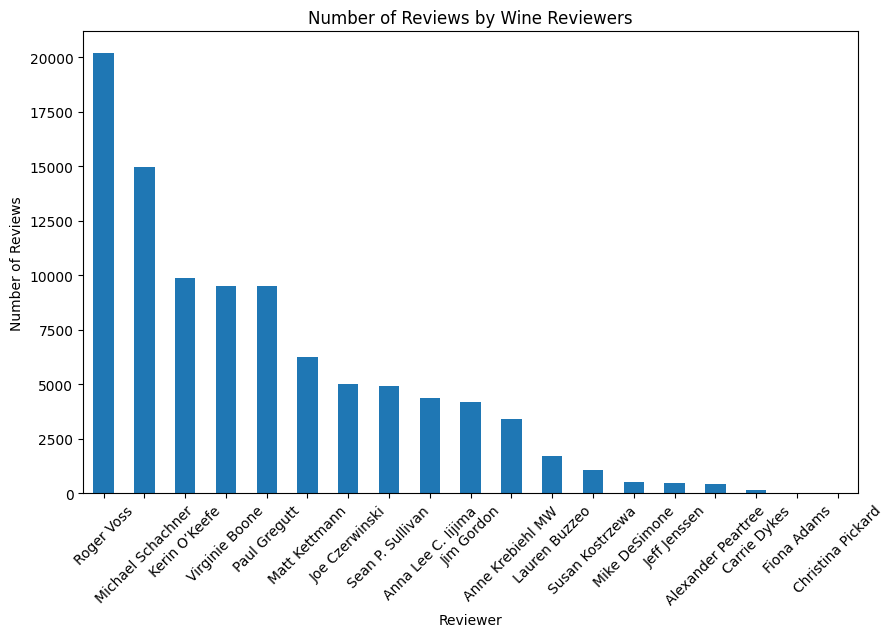

In [84]:
plt.figure(figsize=(10, 6))
wine_data['taster_name'].value_counts().plot(kind='bar')
plt.title('Number of Reviews by Wine Reviewers')
plt.xlabel('Reviewer')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.show()

# 6. Benchmark Pipeline

In [85]:
basic_training = wine_data.copy()
basic_training.head(2)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


# Encoding

Here we encode all the categorial values into a numeric range

In [86]:
label_encoder = LabelEncoder()
basic_training['country'] = label_encoder.fit_transform(basic_training['country'])
basic_training['variety'] = label_encoder.fit_transform(basic_training['variety'])
basic_training['description'] = label_encoder.fit_transform(basic_training['description'])
basic_training['designation'] = label_encoder.fit_transform(basic_training['designation'])
basic_training['region_1'] = label_encoder.fit_transform(basic_training['region_1'])
basic_training['region_2'] = label_encoder.fit_transform(basic_training['region_2'])
basic_training['province'] = label_encoder.fit_transform(basic_training['province'])
basic_training['taster_name'] = label_encoder.fit_transform(basic_training['taster_name'])
basic_training['taster_twitter_handle'] = label_encoder.fit_transform(basic_training['taster_twitter_handle'])
basic_training['title'] = label_encoder.fit_transform(basic_training['title'])
basic_training['winery'] = label_encoder.fit_transform(basic_training['winery'])

In [87]:
basic_training.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
1,1,30,93058,2218,87,15.0,107,1204,17,15,10,82445,445,12196
2,2,39,70255,35776,87,14.0,266,1192,16,14,7,82842,431,12256
3,3,39,56193,26255,87,13.0,216,538,17,0,15,93496,474,13575


In [88]:
training_features = ['country', 'description', 'designation', 'price','province','region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title', 'variety', 'winery']
basic_training_clean = basic_training[training_features+['points']].dropna().copy()
print(basic_training_clean.shape)

# Select features and target
X = basic_training_clean[training_features]
y = basic_training_clean['points']

(120975, 13)


## 6.1 Basic model using XGBoost

Here we will train the model with XGBoost

In [48]:
# This function can run in 90 seconds. For convenience we added the option to load the model. 
ShouldLoad = False

# Split the datset to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Path to save or load the model
model_path = 'models/xgb_simple_model.pkl'

def train_model():
    model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    # Save the model to disk
    pickle.dump(model, open(model_path, 'wb'))
    return model

if ShouldLoad:
    model = pickle.load(open(model_path, 'rb'))
else:
    model = train_model()

# Inference
basic_predictions = model.predict(X_test)
print("Inference complete.")


Inference complete.


## 6.2 Evaluating Basic Model

In [49]:
def evaluate_model(y_true, predictions):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, predictions)
    print(f"MAE:  {mae:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²:   {r2:.2f}")

In [50]:
evaluate_model(y_test, basic_predictions)

MAE:  1.60
MSE:  4.15
RMSE: 2.04
R²:   0.56



We can see that the model has moderate accuracy, and that there's room for improvement.

- MAE (Mean Absolute Error) 1.62, On average, the model's predictions are off by 1.62 units from the true values (The average magnitude of error, no considering whether predictions are too high or too low)

- MSE (Mean Squared Error): 4.24, (squared difference) MSE is more sensitive to large errors because the squaring process amplifies them.

- RMSE (Root Mean Squared Error): 2.06 The square root of the MSE. This brings the error measure back to the same units as your target variable.

We can see the RMSE >> MAE meaning that there are a few particularly bad predictions

- R² (Coefficient of Determination): 0.55 - Approximately 55% of the variation can be explained by your model.

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

def plot_the_data_hist(ax, y_test, predictions):
    # Use histplot with a 2D histogram to create a density heatmap
    sns.histplot(x=y_test, y=predictions, bins=50, pthresh=0.1, cmap="viridis", cbar=True, ax=ax)
    # Diagonal line for reference to show the line of perfect prediction
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    # Setting labels and title using the correct methods
    ax.set_xlabel('Actual Points')
    ax.set_ylabel('Predicted Points')
    ax.set_title('Density Heatmap')

def plot_the_data(ax, y_test, predictions):
    sns.scatterplot(x=y_test, y=predictions, ax=ax)
    # Diagonal line for reference
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
    # Setting labels and title using the correct methods
    ax.set_xlabel('Actual Points')
    ax.set_ylabel('Predicted Points')
    ax.set_title('Actual vs. Predicted Points')

def plot_predictions_vs_gold(y_test, predictions):
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    # Plot regular scatter plot on the first subplot
    plot_the_data(axes[0], y_test, predictions)
    
    # Plot density heatmap on the second subplot
    plot_the_data_hist(axes[1], y_test, predictions)
    
    # Show the complete figure
    plt.tight_layout()
    plt.show()


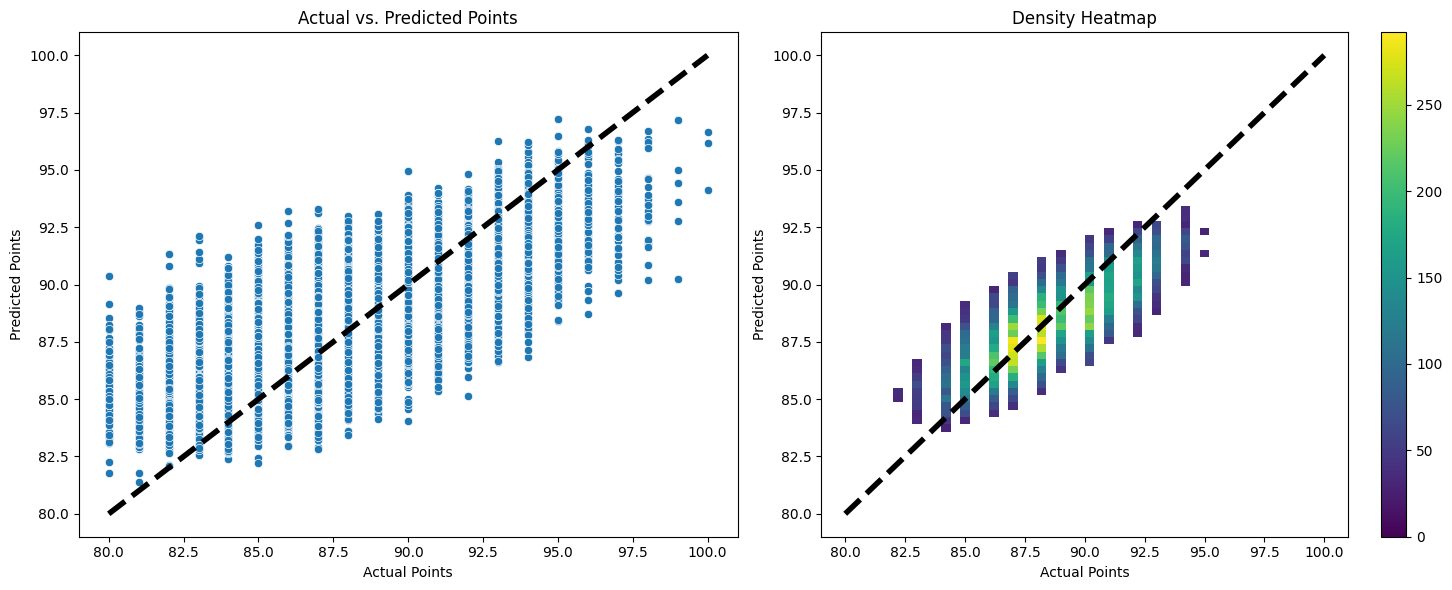

In [121]:
plot_predictions_vs_gold(y_test, basic_predictions)



This scatter plot displays the relationship between actual and predicted points.
The dashed diagonal line represents the line of perfect predictions, where the predicted points would equal the actual points.

The plot reveals that the basic model has moderate predictive power, the predictions deviate from the ideal diagonal line, demonstrating limited accuracy. While the model shows a general ability to predict higher scores for lower quality wines, the slope of this trend doesn't match the ideal expectation. Additionally, the model exhibits a bias, initially overestimating scores for wines around 80 points and then underestimating scores for wines rated around 100 points.

These observations suggest the need for model refinement to improve its prediction accuracy and address the observed biases.

## 6.3  10-fold cross-validation


In [53]:
def plot_cross_validation_graph(scores):
  _reverse_scores = [-score for score in scores]

  # Plot the scores
  plt.figure(figsize=(10, 6))
  plt.plot(_reverse_scores, marker='o', linestyle='--', color='b')
  plt.title('Cross-Validation Scores (MAE) for XGBRegressor')
  plt.xlabel('Fold')
  plt.ylabel('Mean Absolute Error (MAE)')
  plt.grid(True)
  plt.xticks(range(10), range(1, 11))  # Adjust x-ticks to represent fold number
  plt.show()

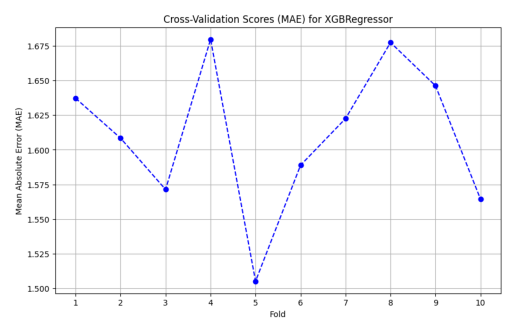

In [56]:
# This can take around 10 minutes. Thus, we can load a saved plot from previous runs:
shouldLoad = True
plot_filename = "models/10Fold_for_simpleXGBoost.png"
if shouldLoad:
    img = plt.imread(plot_filename)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
else:
    basic_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
    print(basic_scores)  # Prints the negative MAE scores
    plot_cross_validation_graph(basic_scores)


The plot illustrates the performance of the XGBRegressor model across ten different folds of cross-validation, using Mean Absolute Error (MAE) as the evaluation metric. Each point on the plot represents the MAE for a single fold; lower values indicate better performance. The model demonstrates a consistent range of MAE values between approximately 1.72 and 1.87, with slight fluctuations across folds, suggesting stable performance despite variations in the test data. The consistency in MAE scores indicates that the model is likely not overfitting to a particular subset of the data and might generalize well to unseen data."

# 7. Improve the ML pipeline as follows

What we faced: While it generally recognizes that higher-rated wines should get higher predicted scores, there are noticeable deviations from the ideal prediction line. This suggests inaccuracy and potential bias, with overestimation at lower scores and underestimation at higher scores.

## 7.1 Perform better feature engineering and extraction

Above we have seen that the price data is very skewed and kurtosis. To help with that we would like to make 

Skewness=1.767
Kurtosis=3.799


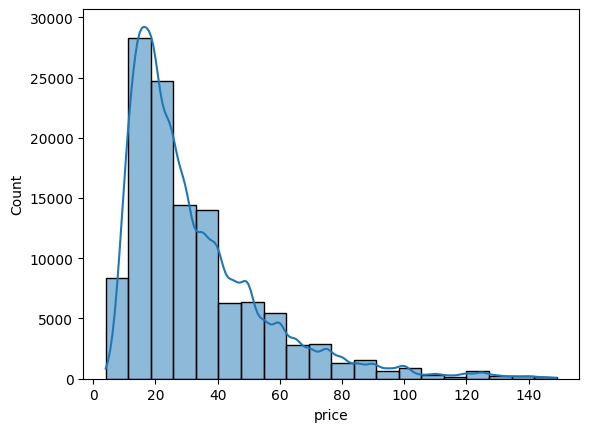

In [104]:
price_less_than150 = wine_data[wine_data['price']<150.0]['price']
print('Skewness=%.3f' %price_less_than150.skew())
print('Kurtosis=%.3f' %price_less_than150.kurtosis())
sns.histplot(price_less_than150, bins=20, kde=True)
plt.show()

Skewness=0.263
Kurtosis=-0.482


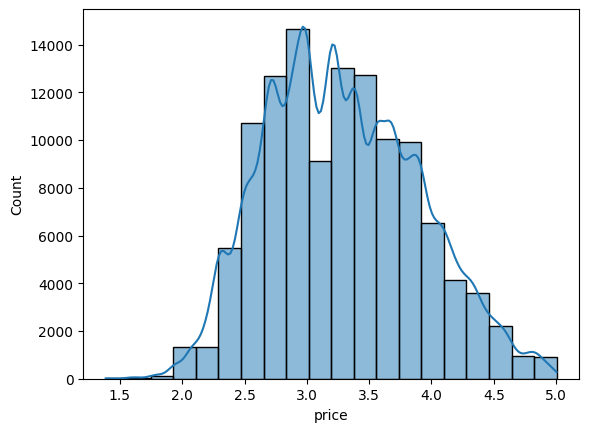

In [105]:
price_less_than150_log = np.log(wine_data[wine_data['price']<150.0]['price'])
print('Skewness=%.3f' %price_less_than150_log.skew())
print('Kurtosis=%.3f' %price_less_than150_log.kurtosis())
sns.histplot(price_less_than150_log, bins=20, kde=True)
plt.show()

In [152]:
training2_log_price = wine_data[wine_data['price']<150.0].copy()
training2_log_price['price'] = np.log(training2_log_price['price'])

### Feature Extraction for the Word Count in the Review

<Axes: xlabel='points', ylabel='word_count'>

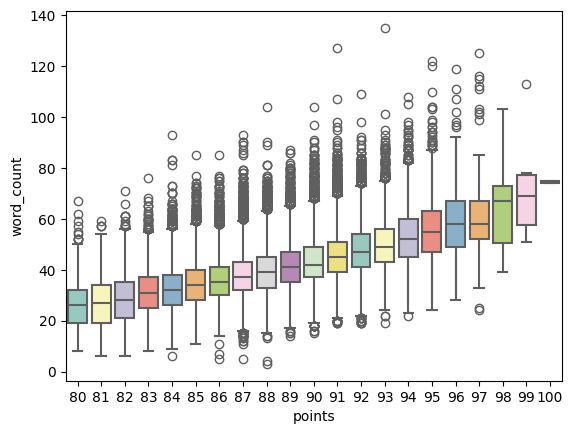

In [153]:
training2_w_sentiment = training2_log_price.copy()
training2_w_sentiment['word_count'] = training2_log_price['description'].apply(lambda x: len(str(x).split(" ")))
sns.boxplot(x='points', y='word_count', hue='points', palette='Set3', data=training2_w_sentiment, linewidth=1.5, legend=False)

In [154]:
training2_w_sentiment['description_sentiment'] = training2_w_sentiment['description'].apply(lambda x: TextBlob(x).sentiment.polarity)

We can see that destributation of the feature we've added - the sentiment of the reviews, the sentiment range is between [-1,1] where 1 is the most positive review.

In [155]:
training2_w_sentiment['description_sentiment'].describe()

count    119505.000000
mean          0.155269
std           0.170327
min          -0.800000
25%           0.041667
50%           0.151667
75%           0.266071
max           1.000000
Name: description_sentiment, dtype: float64

### Top reviews

To understand the scores we print here the top most positive and negative review and their sentiment score.

In [ ]:
top_reviews = training2_w_sentiment.nlargest(3, 'description_sentiment')

# Get the top 3 reviews with the lowest sentiment
bottom_reviews = training2_w_sentiment.nsmallest(3, 'description_sentiment')
pd.set_option('display.max_colwidth', None)
print("Top 3 reviews with the highest sentiment:")
print(top_reviews[['description', 'description_sentiment']], '\n')

print("Top 3 reviews with the lowest sentiment:")
print(bottom_reviews[['description', 'description_sentiment']])

Top 3 reviews with the highest sentiment:
                                                                                                                                                                                                             description  \
1340  Produced from organic grapes, the wine is ripe and packed with fruit. It has a delicious line of acidity, as well as weight and peach and red-fruit flavors. The acidity keeps the exuberance in check. Drink now.   
3159                      This blend of 88% Cabernet Sauvignon and 12% Cabernet Franc is rustic smelling, with a rubbery, tannic mouthfeel and flavors of roasted plum and berry. Let this wine aerate to show its best.   
4719      Anchored in fig, plum and berry fruit, this is a substantial effort for both the vintage and the price. It will show best with hearty, cold-weather dishes. Hints of cinnamon and chocolate extend the finish.   

      description_sentiment  
1340                    1.0  
3159             


### Region2
We try to drop region2 because it is a sub category of region-1 and is 61% null. In the dataset the authoer describe it as "Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley)"

But it will delete most of the data. Since it's not meaningful feature we can jsut drop the feature itself.

In [156]:
del training2_w_sentiment['region_2']
del training2_w_sentiment['description']
del training2_w_sentiment['Unnamed: 0']

In [157]:
print_wine_attributes(training2_w_sentiment)

Wine attributes: 
0. country
1. designation
2. points (Range: 80 - 100)
3. price (Range: 1.3862943611198906 - 5.003946305945459)
4. province
5. region_1
6. taster_name
7. taster_twitter_handle
8. title
9. variety
10. winery
11. word_count (Range: 3 - 135)
12. description_sentiment (Range: -0.8 - 1.0)



- designation
wine_reviews['designation'].fillna('Unknown', inplace = True)
wine_reviews['region_1'].fillna('Unknown', inplace = True)

- taster_name              26244
taster_twitter_handle    31213

In [ ]:
# Remove description, designation, taster_twitter_handle, title, region_1, region_2, taster_twitter_handle
# concise_features = ['price', 'country', 'variety', 'province', 'winery']
# encoded_training2 = training2[concise_features + ['points']].dropna()
# print(encoded_training2.shape)

### Encoding

In [158]:
training2_w_sentiment.region_1.fillna('unknown')
training2_w_sentiment.region_1.fillna('unknown').value_counts().sort_values(ascending = False)

unknown                     19436
Napa Valley                  4283
Columbia Valley (WA)         4108
Russian River Valley         3090
California                   2626
                            ...  
Clairette de Die                1
Clare Valley-Eden Valley        1
Strevi                          1
Australia-New Zealand           1
Grands-Echezeaux                1
Name: region_1, Length: 1182, dtype: int64

In [159]:
# Remove description, designation, title, region_2
encoded_training2 = training2_w_sentiment[['points', 'price', 'word_count', 'description_sentiment', 'country', 'designation', 'province', 'taster_name', 'taster_twitter_handle', 'title', 'region_1', 'variety', 'winery']].copy()
label_encoder = LabelEncoder()
encoded_training2['country'] = label_encoder.fit_transform(encoded_training2['country'])
encoded_training2['designation'] = label_encoder.fit_transform(encoded_training2['designation'])
encoded_training2['province'] = label_encoder.fit_transform(encoded_training2['province'])
encoded_training2['taster_name'] = label_encoder.fit_transform(encoded_training2['taster_name'])
encoded_training2['taster_twitter_handle'] = label_encoder.fit_transform(encoded_training2['taster_twitter_handle'])
encoded_training2['title'] = label_encoder.fit_transform(encoded_training2['title'])
encoded_training2['region_1'] = label_encoder.fit_transform(encoded_training2['region_1'])
encoded_training2['variety'] = label_encoder.fit_transform(encoded_training2['variety'])
encoded_training2['winery'] = label_encoder.fit_transform(encoded_training2['winery'])

In [160]:
encoded_training2.head(1)

,points,price,word_count,description_sentiment,country,designation,province,taster_name,taster_twitter_handle,title,region_1,variety,winery
1,87,2.70805,39,0.22,30,2194,107,15,10,81325,1181,444,12127


In [161]:
# Select features and target
X2 = encoded_training2.drop('points', axis=1).copy()
y2 = encoded_training2['points']

### Training based on the feature extraction dataset

In [180]:
# This function can run in 60 seconds. For convenience we added the option to load the model. 
ShouldLoad = False

# Split the datset to train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Path to save or load the model
model_path = 'models/xgb_secondTime_model.pkl'

def train_model():
    model2 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
    model2.fit(X_train2, y_train2, eval_set=[(X_test2, y_test2)], verbose=False)
    # Save the model to disk
    pickle.dump(model, open(model_path, 'wb'))
    return model2

if ShouldLoad:
    model2 = pickle.load(open(model_path, 'rb'))
else:
    model2 = train_model()

# Inference
predictions2 = model2.predict(X_test2)
print("Inference complete.")




Inference complete.


In [182]:
predictions2 = model2.predict(X_test2)
evaluate_model(y_test2, predictions2)

MAE:  1.41
MSE:  3.25
RMSE: 1.80
R²:   0.64


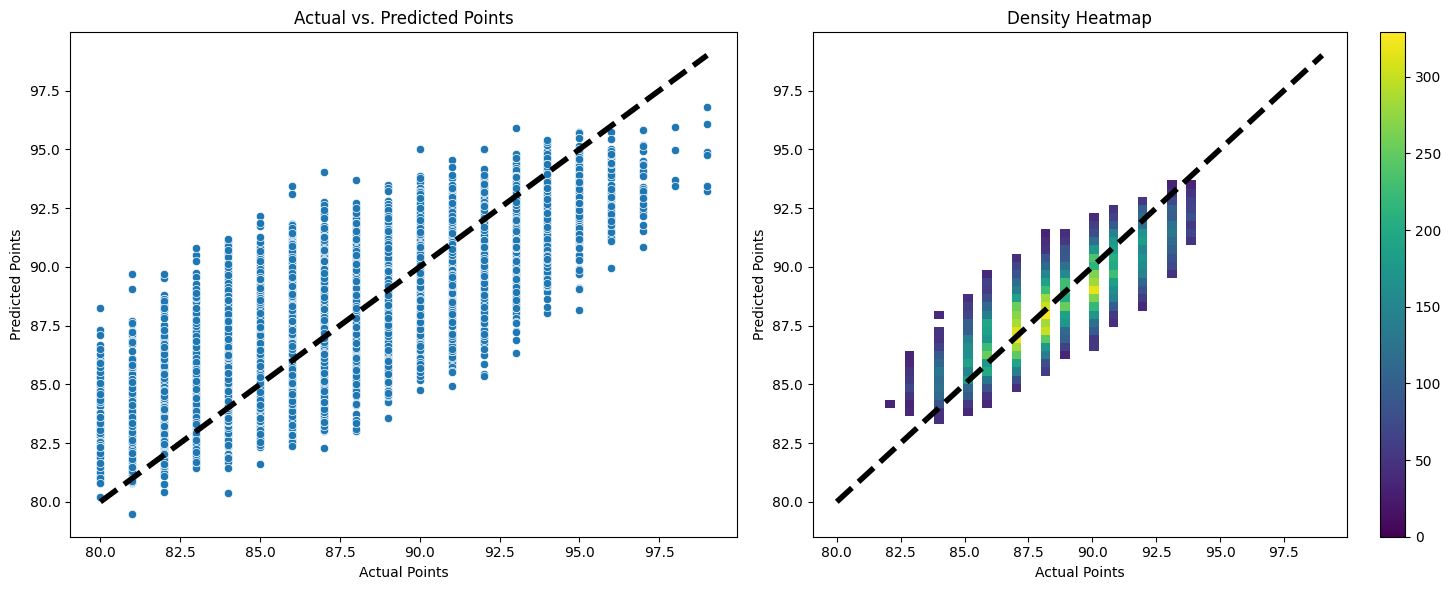

In [183]:
plot_predictions_vs_gold(y_test2, predictions2)

In [ ]:
scores2 = cross_val_score(model2, X2, y2, cv=10, scoring='neg_mean_absolute_error')
print(scores2)

## 7.2 Implement/Choose a better ML model

###  Iterate over various models training

Training LinearRegression...
Training Ridge...
Training Lasso...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e+05, tolerance: 8.741e+01
  model = cd_fast.enet_coordinate_descent(


Training DecisionTreeRegressor...
Training RandomForestRegressor...
Training SVR...
Training XGBRegressor...

MAE:  1.65
MSE:  4.34
RMSE: 2.08
R²:   0.52

MAE:  1.65
MSE:  4.34
RMSE: 2.08
R²:   0.52

MAE:  2.04
MSE:  6.49
RMSE: 2.55
R²:   0.29

MAE:  1.88
MSE:  6.74
RMSE: 2.60
R²:   0.26

MAE:  1.42
MSE:  3.45
RMSE: 1.86
R²:   0.62

MAE:  2.42
MSE:  8.88
RMSE: 2.98
R²:   0.02

MAE:  1.43
MSE:  3.33
RMSE: 1.83
R²:   0.63


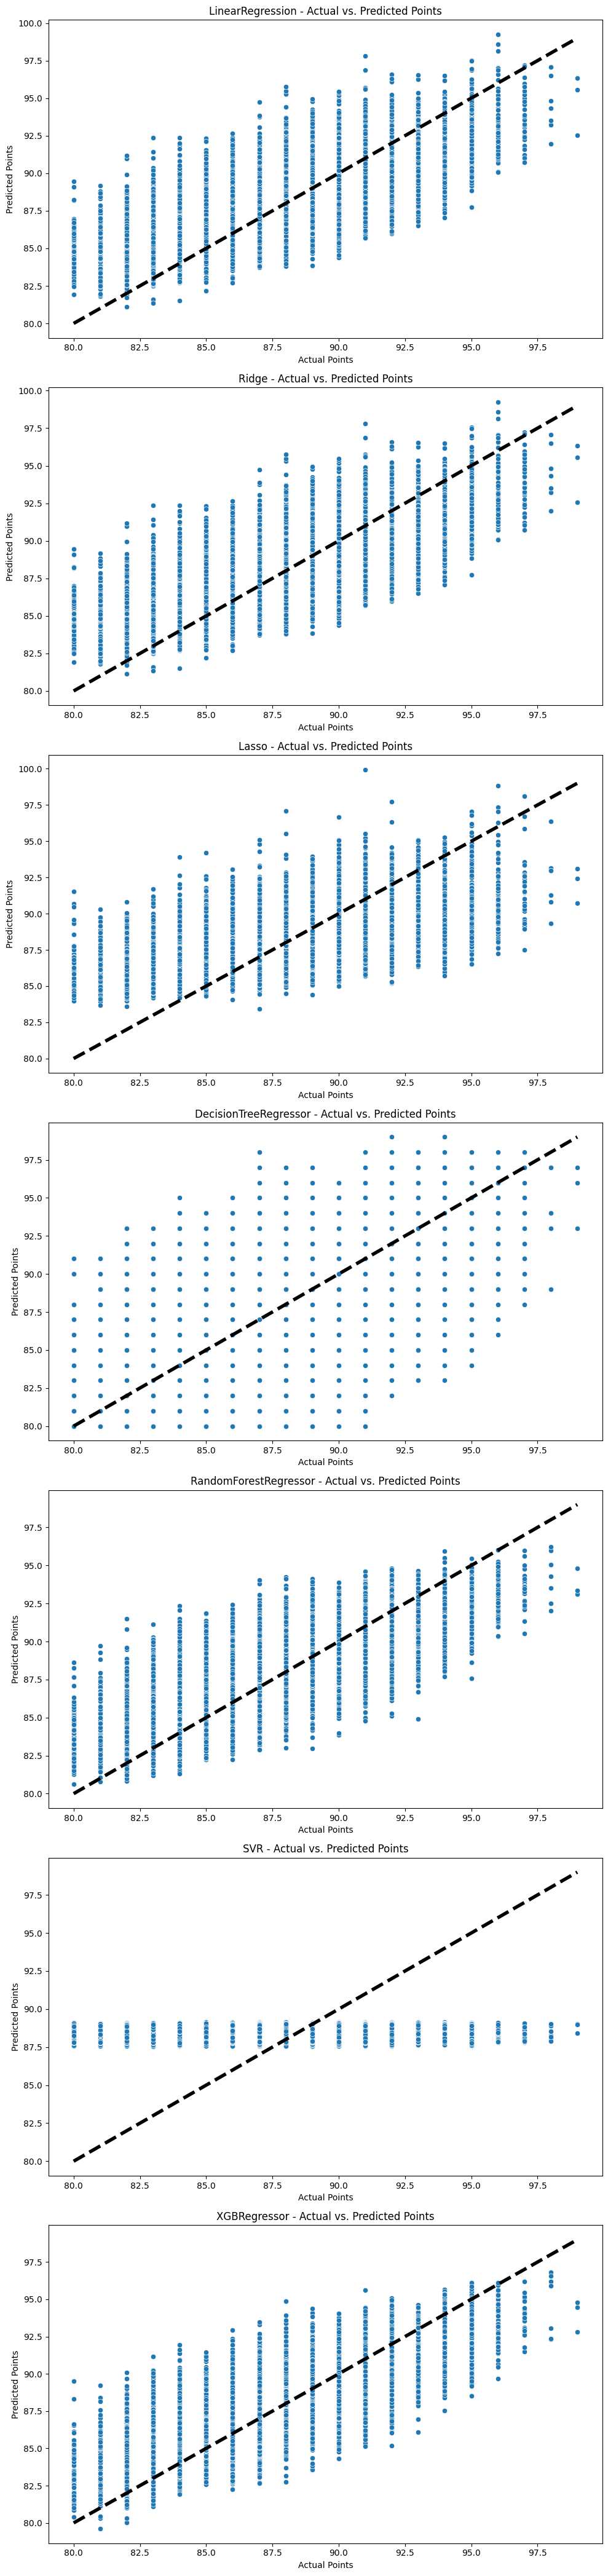

In [ ]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import numpy as np


models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100),
    'XGBRegressor': XGBRegressor(n_estimators=1000, learning_rate=0.05)
}

model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

predictions = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train2, y_train2)
    joblib.dump(model, f"{models}/{model_name}.joblib")
    predictions[model_name] = model.predict(X_test2)

num_models = len(models)
fig, axes = plt.subplots(nrows=num_models, ncols=1, figsize=(10, 6 * num_models))

for i, (model_name, model_preds) in enumerate(predictions.items()):
    print()
    evaluate_model(y_test2, model_preds)
    sns.scatterplot(x=y_test2, y=model_preds, ax=axes[i])
    axes[i].plot([y_test2.min(), y_test2.max()], [y_test2.min(), y_test2.max()], 'k--', lw=4)  # Diagonal line
    axes[i].set_xlabel('Actual Points')
    axes[i].set_ylabel('Predicted Points')
    axes[i].set_title(f'{model_name} - Actual vs. Predicted Points')

plt.tight_layout()
plt.show()

### Model CatBoostRegressor

In [ ]:
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=10, loss_function='RMSE', verbose=False)
catboost_model.fit(X_train2, y_train2, eval_set=[(X_test2, y_test2)], early_stopping_rounds=5)

In [ ]:
catboost_predictions = catboost_model.predict(X_test2)

## 7.3 statistical evaluation

In [ ]:
evaluate_model(y_test2, predictions2)

MAE:  1.45
MSE:  3.38
RMSE: 1.84
R²:   0.63


In [ ]:
evaluate_model(y_test2, catboost_predictions)

MAE:  1.44
MSE:  3.36
RMSE: 1.83
R²:   0.63


## 7.4 Error analysis

TODO run analysis didn't finish

In [ ]:
from catboost import Pool, CatBoostRegressor, cv

def run_error_analysis(y_test, predictions):
  predictions = pd.Series(predictions)
  errors = y_test - predictions

  # Basic Error Analysis plot
  plt.figure(figsize=(10, 6))
  sns.histplot(errors, kde=True)
  plt.title('Distribution of Prediction Errors')
  plt.xlabel('Error')
  plt.ylabel('Frequency')
  plt.show()

  # Scatter plot of actual vs predicted with error distribution
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=y_test, y=predictions, hue=np.abs(errors), palette='coolwarm')
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line
  plt.title('Actual vs Predicted Points with Error Heatmap')
  plt.xlabel('Actual Points')
  plt.ylabel('Predicted Points')
  plt.show()

  # Step 3: Use SHAP to explain the model's predictions
  explainer = shap.Explainer(model)
  shap_values = explainer(X_test)

  # Step 4: Visualize the errors using SHAP
  # Here we plot the SHAP values of the 10 most incorrect predictions

  # Get the indices of the 10 largest errors
  indices_largest_errors = np.argsort(np.abs(errors))[-10:]

  # Summary plot for the instances with the largest errors
  shap.summary_plot(shap_values[indices_largest_errors], X_test.iloc[indices_largest_errors])

  # Detailed SHAP value plot for the single worst prediction
  index_worst_prediction = indices_largest_errors[-1]
  shap.plots.waterfall(shap_values[index_worst_prediction], max_display=10)

  # Display all plots
  plt.show()


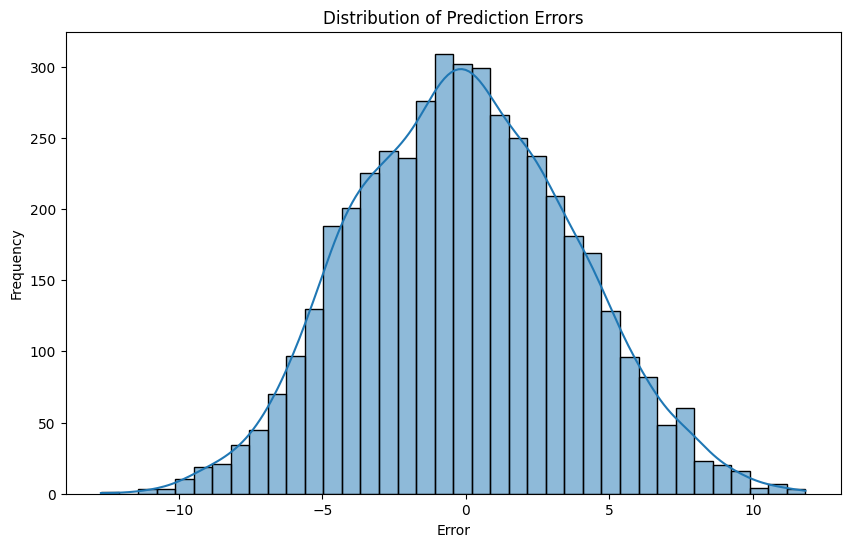

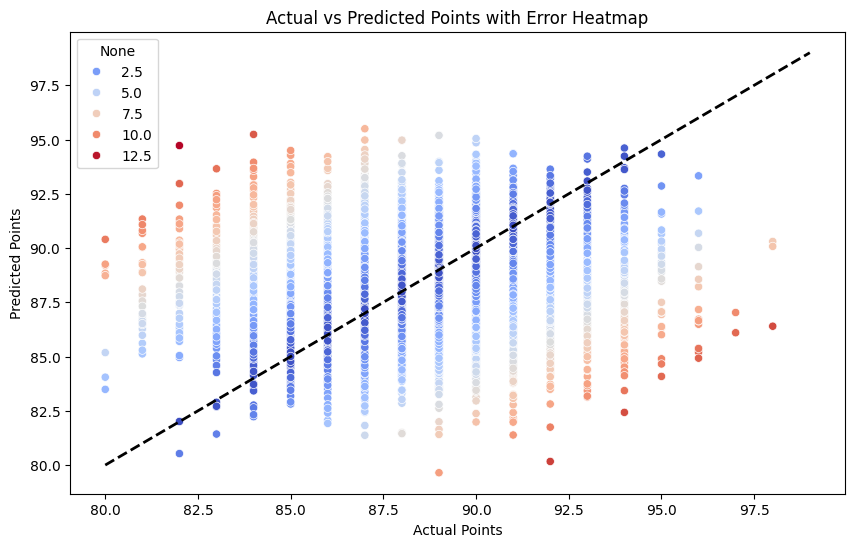

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
run_error_analysis(y_test2, predictions2)

# 8. SHAP - Feature importance tools

In [186]:
import shap

def plot_shap(model, X_test, plot_filename):

  explainer = shap.TreeExplainer(model)
  shap_values = explainer.shap_values(X_test)

  index_to_explain = 0
  expl = shap.Explanation(values=shap_values[index_to_explain],
                          base_values=explainer.expected_value,
                          data=X_test.iloc[index_to_explain],
                          feature_names=X_test.columns.tolist())

  # Waterfall plot for the same individual prediction
  # shap.plots.waterfall(expl, max_display=14)  # Adjust 'max_display' to show more or fewer features

  shap.summary_plot(shap_values, X_test, plot_type="bar")
  shap.summary_plot(shap_values, X_test)

  # Example of a dependence plot for a feature
  # shap.dependence_plot('price', shap_values, X_test)

  # # Plot for individual prediction contribution
  # shap.initjs()
  # shap.force_plot(explainer.expected_value, shap_values[index_to_explain, :], X_test.iloc[index_to_explain, :])

  plt.show()
  return plt.gcf()

This plot show how well each feature is important to the prediction

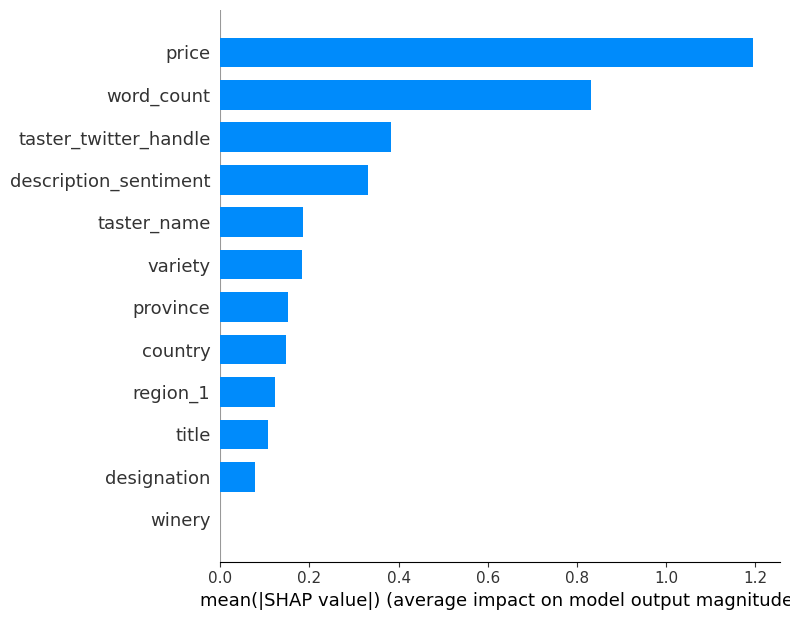

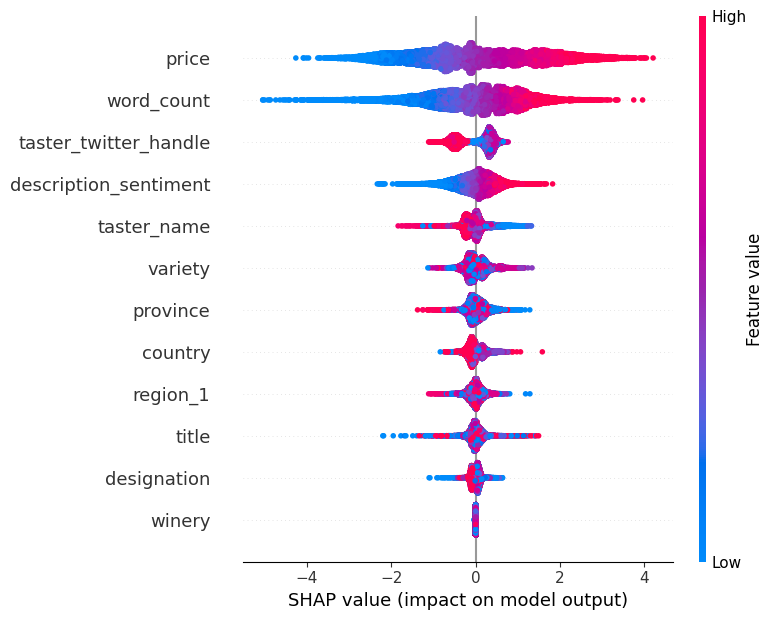

<Figure size 640x480 with 0 Axes>

In [187]:
shouldLoad = False
plot_filename = "models/shap_xgb_second_time.png"
if shouldLoad:
    img = plt.imread(plot_filename)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
else:
    fig = plot_shap(model2, X_test2)
    fig.savefig(plot_filename)

Word Count: The SHAP plot reveals that a higher word count (indicated by red) tends to push the SHAP value to the right, suggesting a positive impact on the model's output, typically increasing the predicted value. This could indicate that more verbose descriptions correlate with certain qualities or perceptions of the wine that align with higher ratings or values.
Price: Similarly, a higher price, also shown in red, has a predominantly rightward effect on the SHAP values, which implies that higher prices positively influence the model’s predictions. This is intuitive as higher-priced wines are often perceived to be of higher quality.

# 9. Insights

In [188]:
insights_training_data = encoded_training2.copy()

# Heatmap


Strong positive correlation between:
- 'price' and 'points' could suggest that higher-rated wines tend to be more expensive

Strong negative correlation between:
- 'price' and 'description_sentiment', might indicate that wines with lower sentiment scores (potentially more negative descriptions) are cheaper


This image displays a correlation heatmap, which is a graphical representation of the correlation matrix between numerical variables in a dataset. In a correlation heatmap:

- Each cell shows the correlation coefficient between two variables, represented by the intersection of the corresponding row and column.
- The value of the correlation coefficient ranges from -1 to 1, where:
  - *1* indicates a perfect positive correlation, meaning as one variable increases, the other also increases.
  - *-1* indicates a perfect negative correlation, meaning as one variable increases, the other decreases.
  - *0* indicates no correlation, meaning the variables do not have a linear relationship.
- The color scale (often from red to white to blue) represents the strength and direction of the correlation. Typically, a darker red indicates a stronger positive correlation, and a darker blue indicates a stronger negative correlation. Lighter colors or white represent weaker correlations.
  
From the heatmap in the image:
- The diagonal from the top-left to bottom-right is always 1 (dark red) because it represents the correlation of each variable with itself, which is always perfect.
- The points variable has a moderately positive correlation (0.6) with price, indicating that as the price of wine increases, the points (or rating) also tend to be higher.
- There is a significant positive correlation (0.53) between word_count and points, suggesting that reviews with more words tend to have higher ratings.
- taster_name and taster_twitter_handle have a strong positive correlation (0.55), which is expected as these are likely related to the same individual.
- The description_sentiment shows a small positive correlation (0.15) with points, hinting that more positively worded reviews might correlate with slightly higher wine ratings.


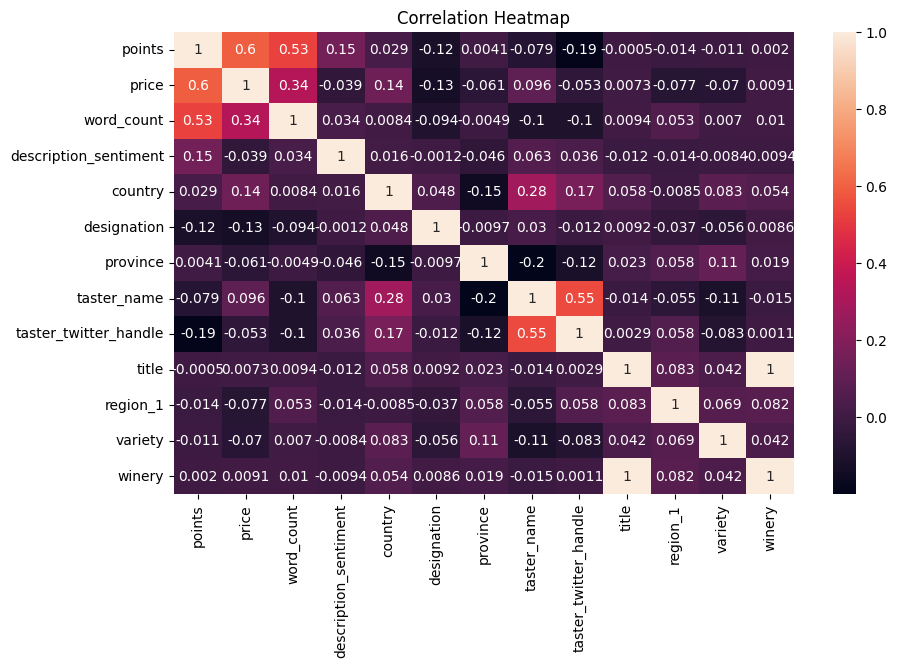

In [189]:
plt.figure(figsize=(10, 6))
sns.heatmap(insights_training_data.corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

Heatmaps typically visualize correlations between numerical features. Categorical features (like 'region_1') would need different visualization techniques (e.g., bar charts)

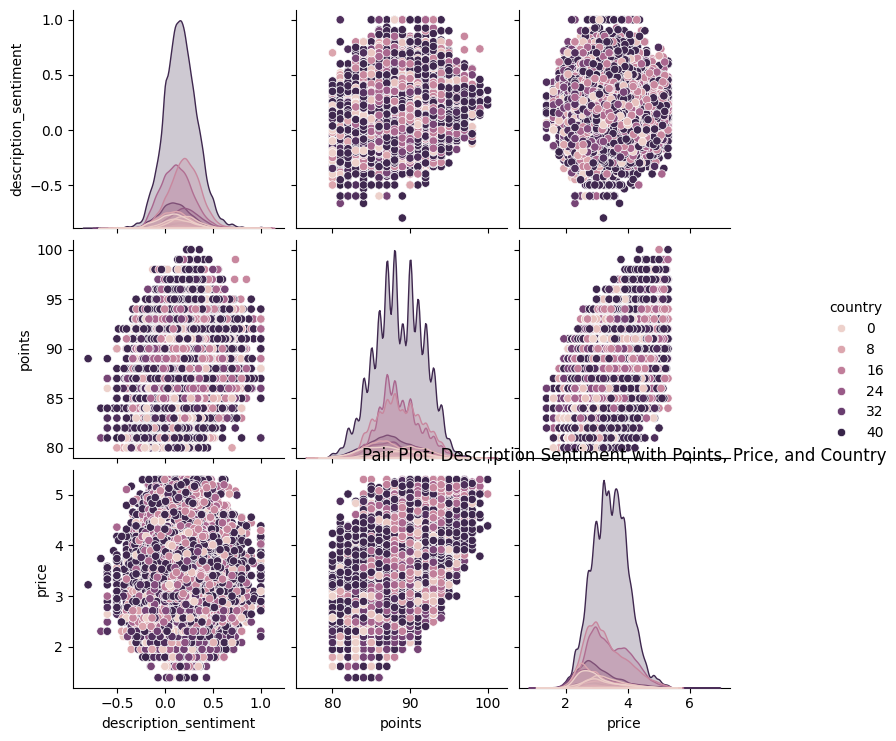

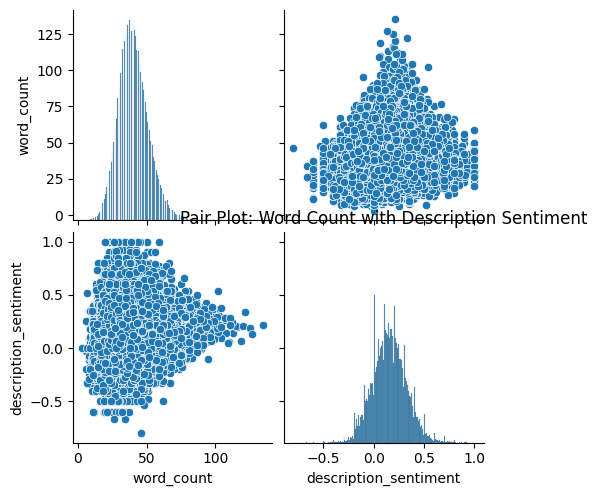

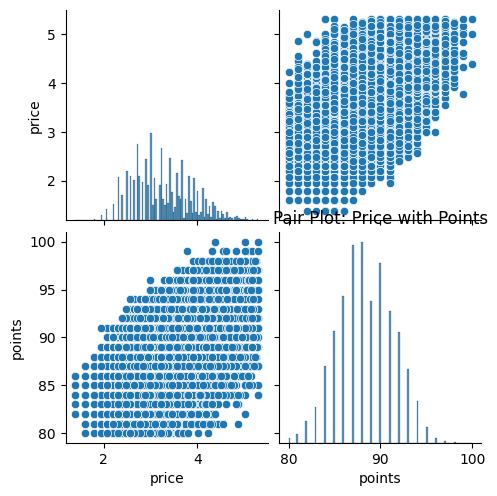

KeyError: 'region'

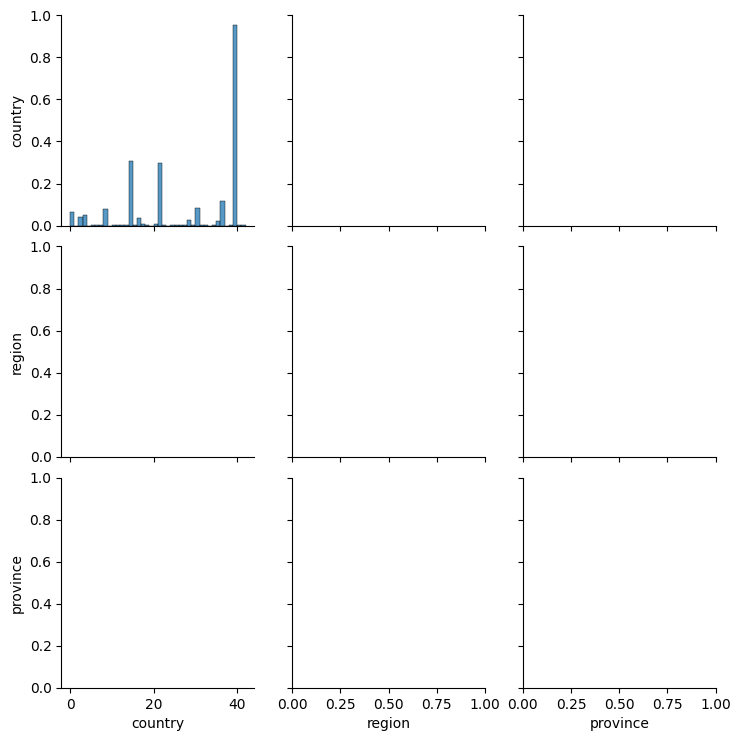

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pair plot for description_sentiment with points, price, and country
sns.pairplot(insights_training_data, vars=["description_sentiment", "points", "price"], hue="country")
plt.title("Pair Plot: Description Sentiment with Points, Price, and Country")
plt.show()

# Pair plot for word_count and description_sentiment
sns.pairplot(insights_training_data, vars=["word_count", "description_sentiment"])
plt.title("Pair Plot: Word Count with Description Sentiment")
plt.show()

# Pair plot for price and points
sns.pairplot(insights_training_data, vars=["price", "points"])
plt.title("Pair Plot: Price with Points")
plt.show()

In [484]:
# Density plots for numerical features
numerical_cols = ['price', 'points', 'description_sentiment']
insights_training_data.plot(kind='density', subplots=True, layout=(2, 2), figsize=(10, 10),  title='Density Plots', colormap='viridis', sharex=False)
plt.show()


ValueError: Layout of 2x2 must be larger than required size 13

<Figure size 1000x1000 with 0 Axes>

# 10. Refer in your project to existing material


While the Wine Reviews dataset on Kaggle offers a wealth of existing notebooks for analysis, most concentrate on fundamental data analysis, manipulation techniques, and demonstrations of core concepts.  We've identified a few notebooks with relevant approaches, yet our solution offers distinct advantages:

-  Predict Wine Points: how to pick a wine
https://www.kaggle.com/code/kb2900/predict-wine-points-how-to-pick-a-wine

- Predicting Wine Quality using SVM,KNN(with EDA)

- https://www.kaggle.com/code/darthmanav/predicting-wine-quality-using-svm-knn-with-eda

- Good with cheeseburgers: predict wine from reviews
https://www.kaggle.com/code/kevintos/good-with-cheeseburgers-predict-wine-from-reviews

-  Predicting Wine Ratings Using LightGBM + Text2Vec
- https://www.kaggle.com/code/nnnnick/predicting-wine-ratings-using-lightgbm-text2vec

- Predict a wine's score based on its description (https://www.kaggle.com/code/inmanenz/predicting-wine-reviewers)

- Classification with NLP, XGBoost and Pipelines
 https://www.kaggle.com/code/diveki/
classification-with-nlp-xgboost-and-pipelines

- NLP + feature based points predictions
https://www.kaggle.com/code/mistrzuniu1/nlp-feature-based-points-predictions

https://www.kaggle.com/code/alabaj/wine-reviews-classification-tensorflow-lstm
- https://www.kaggle.com/code/sajjadfc13/day-1-regression-and-classification

-  Wine Analysis + Recommendation
- https://www.kaggle.com/code/chaitanya99/wine-analysis-recommendation


Unlike notebooks focusing on basic wine scores or quality predictions (like [Predicting Wine Quality using SVM,KNN], [Good with cheeseburgers], or [Predicting Wine Ratings Using LightGBM + Text2Vec]), our solution XXXX..TODO..

Our approach surpasses classification-centered notebooks ([Classification with NLP, XGBoost and Pipelines], [NLP + feature based points predictions]), offering...XXXXX

We build upon the strengths of analysis and recommendation works ([Wine Analysis + Recommendation]) by... showcase how we enhance these aspects

This positions our solution as a valuable extension of existing work on the Wine Reviews dataset, filling a gap by providing... Summarize the unique benefits my solution brings to the table
"


## how and why your pipeline is different from other available pipelines. Mention and provide citation/reference to any external resource (code, idea, technique) that you use.

# 11. Present the main, important parts of your full data science workflow and results in a user
friendly human-readable Jupyter Notebook, that contains markup, visualizations and short
block of code (long block should be deferred to external python files). Explain, and show how
you improved over the baseline model.